# Initial Exploratory Data Analysis of Reddit Searchs

Using the raw data scraped by PRAW: The Python Reddit API Wrapper, the titles and post descriptions are combined, cleaned, and turned into bi-grams. The list of bi-grams is then listed by count and put into a bar graph

In [213]:
import pandas as pd
import numpy as np
import nltk
from pathlib import Path
import os
from typing import Union
import matplotlib.pyplot as plt

PROJECT_DIR = Path(os.path.abspath('')).resolve().parents[0]

In [ ]:
nltk.download('punkt')

In [245]:
all_la_pk_reg = pd.read_json(PROJECT_DIR / 'data/raw/ALLla_parking_regulation.json')
all_la_pk_reg.head()

,title,permalink,selftext,upvote_ratio,url,votes
0,[Los Angeles] Looks like LADOT parking regulat...,/r/SoCalCoronavirus/comments/hamtea/los_angele...,,1.00,https://www.facebook.com/ladotofficial/photos/...,14
1,[Los Angeles] - List of Certain Parking Regula...,/r/SoCalCoronavirus/comments/gnmcng/los_angele...,Per Councilman Huizar:\n\nConsistent with exte...,1.00,https://www.reddit.com/r/SoCalCoronavirus/comm...,2
2,Valet parking regulations to be considered by ...,/r/LosAngeles/comments/13epqd/valet_parking_re...,,0.96,http://www.latimes.com/news/local/la-me-valet-...,17
3,Gov. Newsom Signs Law Clearing Way for Regulat...,/r/kawaraban/comments/c60r8w/gov_newsom_signs_...,,1.00,https://ktla.com/2019/06/26/gov-newsom-signs-n...,1
4,@NBCNews: Santa Anita Park near Los Angeles re...,/r/newsbotbot/comments/bytl1d/nbcnews_santa_an...,,1.00,https://mobile.twitter.com/NBCNews/status/1137...,1


In [209]:
def create_bigrams(input_file: Union[str, Path]) -> list: 
    ''' Creates list of bi-grams from input_file'''
    df = pd.read_json(input_file)
    df['title_selftext'] = df['title'] + df['selftext']
    df['title_selftext'] = df['title_selftext'].apply(lambda x: x.lower())
    df['tokens'] = df.title_selftext.apply(lambda x: nltk.RegexpTokenizer(r'\w+').tokenize(x))
    df['bigrams'] = df['tokens'].apply(nltk.bigrams)
    return [' '.join(item) for sublist in df.bigrams for item in sublist]



In [243]:
bigram_list = []
for path in (PROJECT_DIR / 'data' / 'raw').glob("*.json"):
    bigram_list = bigram_list + create_bigrams(path)

In [246]:
combined_bigrams = pd.Series(bigram_list)
biggram_counts = combined_bigrams[combined_bigrams.str.contains('parking')].value_counts()
biggram_counts[:10]

parking enforcement     91
angeles parking         91
parking lot             74
a parking               31
the parking             30
parking regulations     28
relaxed parking         27
parking garage          20
no parking              19
parking restrictions    18
dtype: int64

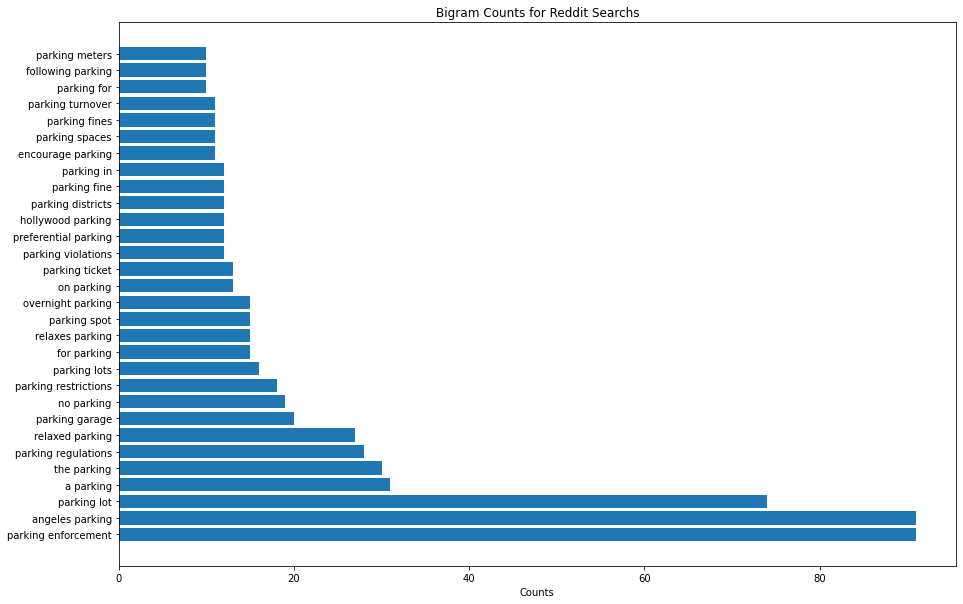

In [248]:
plt.figure(figsize=(15,10))
plt.barh(biggram_counts[:30].index, biggram_counts[:30].values)
plt.title('Bigram Counts for Reddit Searchs')
plt.xlabel('Counts')
plt.savefig(PROJECT_DIR / 'reports/figures' / 'tot_bigram_bar.png')